In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.layers import Dropout, Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
np.random.seed(0)

In [4]:
with open('german-traffic-signs/train.p', 'rb') as f: #storing in variable f
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(test_data))

<class 'dict'>


In [5]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images not equal to number of labels" 
assert(X_val.shape[0] == y_val.shape[0]), "The number of images not equal to number of labels" 
assert(X_test.shape[0] == y_test.shape[0]), "The number of images not equal to number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are ot 32*32*3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are ot 32*32*3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are ot 32*32*3"

In [7]:
import pandas as pd
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

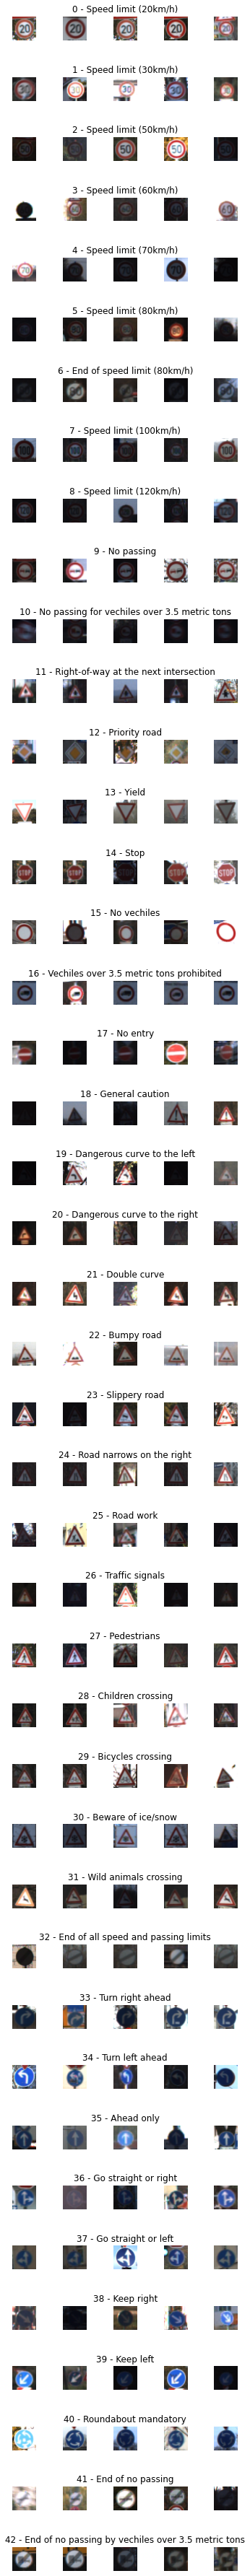

In [8]:
#Plotting image belonging to every class
import random
num_of_samples=[]
cols = 5
num_classes = 43
  
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
  
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


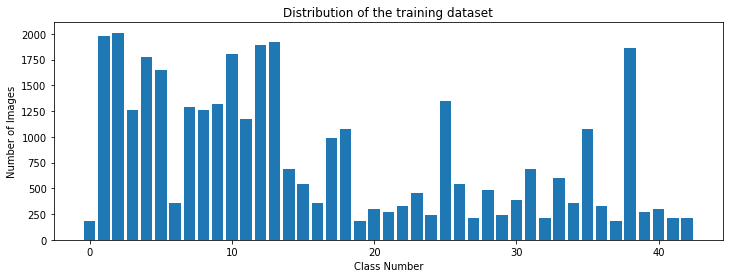

In [9]:
# Training data distribution
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.show()



---


# ***The bar-graph shows that the variation in number of images range from 180 to 2010 thus, we have to preprocess the data accordingly.***

---





(32, 32, 3)
36


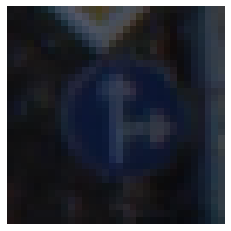

In [10]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(-0.5, 31.5, 31.5, -0.5)

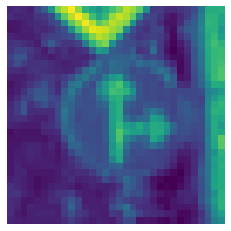

In [11]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")

# **USING HISTOGRAM EQUALIZATION TO EVEN UP THE LIGHTING IN TRAINING DATA.**

(-0.5, 31.5, 31.5, -0.5)

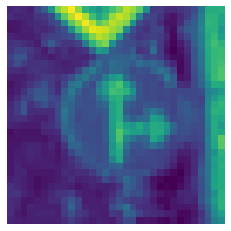

In [12]:
def equalize(img):
  cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis('off')

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255 #normalizing
  return img

X_train = np.array(list(map(preprocessing, X_train))) #Preprocessing
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


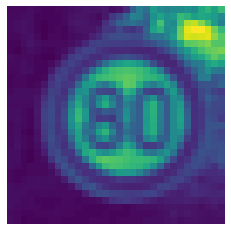

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

# **ADDING DEPTH TO THE DATA BY RESHAPING IT**

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [0]:
#Data Augmentation
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   zoom_range = 0.2, # zoom from 0.8 to 1.2
                   shear_range = 0.1,
                   rotation_range = 10)
datagen.fit(X_train)

(15, 32, 32, 1)


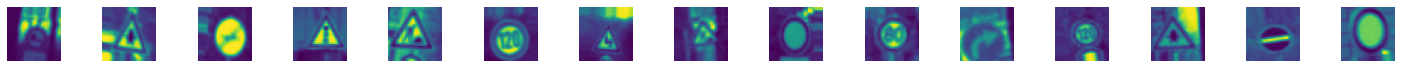

In [17]:
#Create new images
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
#One hot encoding labels
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [0]:
def LeNet_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model = LeNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 540)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               270500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0

In [22]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, 
                              validation_data = (X_val, y_val), shuffle = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
2000/2000 [==============================] - 32s 16ms/step - loss: 1.6186 - accuracy: 0.5329 - val_loss: 0.5149 - val_accuracy: 0.8426
Epoch 2/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.6811 - accuracy: 0.7896 - val_loss: 0.3234 - val_accuracy: 0.9034
Epoch 3/10
2000/2000 [==============================] - 31s 16ms/step - loss: 0.4838 - accuracy: 0.8519 - val_loss: 0.2774 - val_accuracy: 0.9209
Epoch 4/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.3882 - accuracy: 0.8807 - val_loss: 0.2640 - val_accuracy: 0.9209
Epoch 5/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.3318 - accuracy: 0.8975 - val_loss: 0.2258 - val_accuracy: 0.9361
Epoch 6/10
2000/2000 [==============================] - 31s 15ms/step - loss: 0.2894 - accuracy: 0.9105 - val_loss: 0.2114 - val_accuracy: 0.9383
Epoch 7/10
2000/2000 [==========================

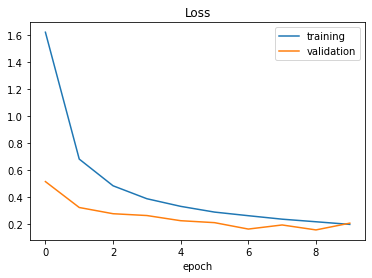

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

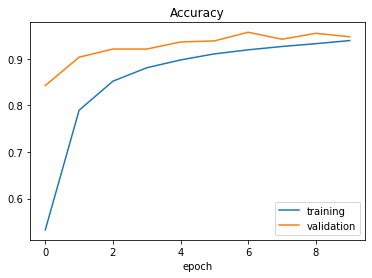

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [25]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.22382822632789612
Test accuracy: 0.9458432197570801


# **OBSERVATION**


*   From **Loss vs Epoch Graph**, it is observed that the validation loss > than 
*  Since the validation accuracy is trailing behind the training accuracy, it seems that the model has overfitted the train data.
*   The accuracy is low

Due to large number of classes, low training data count, it is necessary to **tune the model well.**



# **MODEL TUNING**
The following modifications are made to tune model: 


1.   Learning rate is set to 0.001
2.   Doubling the number of filters in each layer.
3. Adding a new convolution Filter
4. Adding new dropout layer






In [0]:
 def optimized_LeNet():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
model_new = optimized_LeNet()
print(model_new.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [28]:
history_new = model_new.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, 
                              validation_data = (X_val, y_val), shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 36s 18ms/step - loss: 1.0875 - accuracy: 0.6865 - val_loss: 0.2434 - val_accuracy: 0.9351
Epoch 2/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.2869 - accuracy: 0.9124 - val_loss: 0.1177 - val_accuracy: 0.9678
Epoch 3/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.1758 - accuracy: 0.9471 - val_loss: 0.0645 - val_accuracy: 0.9805
Epoch 4/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.1324 - accuracy: 0.9599 - val_loss: 0.0778 - val_accuracy: 0.9810
Epoch 5/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.1075 - accuracy: 0.9677 - val_loss: 0.0715 - val_accuracy: 0.9828
Epoch 6/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.0894 - accuracy: 0.9728 - val_loss: 0.0903 - val_accuracy: 0.9810
Epoch 7/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.0811 - accuracy: 0.9762 - val_loss: 0.0427 -

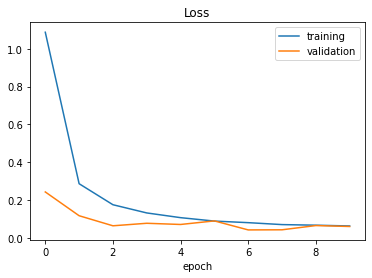

In [29]:
plt.plot(history_new.history['loss'])
plt.plot(history_new.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

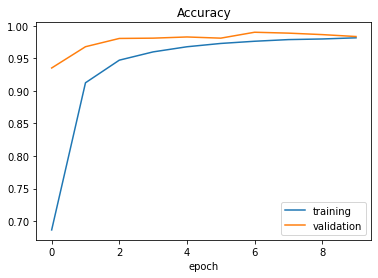

In [30]:
plt.plot(history_new.history['accuracy'])
plt.plot(history_new.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [31]:
score_new = model_new.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.22382822632789612
Test accuracy: 0.9458432197570801


# **TESTING**

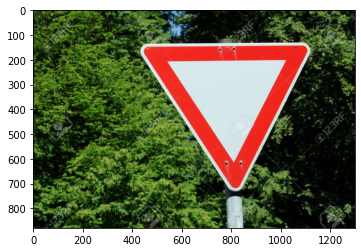

In [32]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


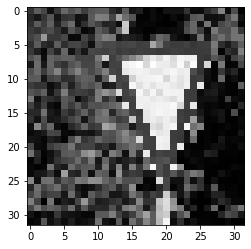

In [33]:
#Preprocessing the image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
#Reshape
img = img.reshape(1, 32, 32, 1)

In [35]:
#Test image
print("predicted sign: "+ str(model_new.predict_classes(img)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
predicted sign: [13]


# **FIT GENERATOR**
The model is not performing very good on test set, so we need to perform image augmentation. 

# **SAVING THE MODEL**

In [36]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
